# Applicability Domain Workflow

### Introduction

Workflow for estimation of Applicability Domain (AD) based on Euclidean distances. 

The AD of a QSAR model must be defined to flag compounds in the test set for which predictions may be unreliable. In this workflow, similarity measurements are used to define the AD of the model based on the Euclidean distances among all the compounds of the training set. Then, we estimate if compounds of the test are inside the AD of the training set. The distance of a test compound to its nearest neighbor in the training set is compared to the calculated AD Threshold (ADT) of the training set. If the similarity is beyond this threshold, the prediction is considered unreliable.

ADT is calculated as follows: 

ADT = D + Zσ 

where where Z is a similarity threshold parameter defined by the user (default is 0.5), and D and σ are the average and standard deviation, respectively, of all Euclidian distances in the multidimensional descriptor space between each compound and its nearest neighbors for all compounds in the training set.

This method has been defined by A. Golbraikh, M. Shen, Z. Xiao, Y.-D. Xiao, K.-H. Lee, A. Tropsha. J. Comput. Aided. Mol. Des. 2003, 17 (2–4), 241–253.

In [26]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix

### ADT function

In [2]:
def calc_training_dist_matrix(training_descriptors):
    """Calculate the distance of every compound in the training set
    from every other compound in the training set."""
    return np.sort(distance_matrix(training_descriptors,training_descriptors),axis=1)[:,1:]

def calc_d_cutoff(distance_matrix, user_cutoff=0.5):
    """Calculate the cutoff value defining the applicability domain
    for the entire training set."""
    average_dist = np.mean(distance_matrix, axis=None)
    std_dev = np.std(distance_matrix, axis=None)
    return (average_dist + user_cutoff * std_dev)

def calc_test_distances(testing_descriptors,training_descriptors):
    """Calculate distance of each compound in the test set
    from every compound in the training set"""
    return distance_matrix(testing_descriptors,training_descriptors)

def test_AD(test_value,threshold):
    """Return boolean value for compound; 1 if compound in AD, 0 if not."""
    if test_value < threshold:
        return 1
    return 0

def percent_reliable(test_df):
    """Return the portion of compounds in the test set that have been calculated to be reliable."""
    count_reliable = len(test_df[test_df.Applicability_Domain == "Reliable"])
    return count_reliable/len(test_df)

In [30]:
trainset_df = pd.read_csv('Anti.csv')
smilesList = trainset_df.smiles.values
print("number of all smiles: ",len(smilesList))

number of all smiles:  2928


In [33]:
trainset_mol_list = []
remained_smiles = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        remained_smiles.append(smiles)
        trainset_mol_list.append(mol)
    except:
        print("not successfully processed smiles: ", smiles)
        pass

Anti                                   smiles   cas  \
0        0                   S=P(N1CC1)(N1CC1)N1CC1  2621   
1        0           S=C1SCN(Cc2ccccc2)CN1Cc1ccccc1  2620   
2        0                    S=c1[nH]cnc2nc[nH]c12  2619   
3        0                           S=C=NCc1ccccc1  2618   
4        0                     S=C=Nc1ccc(N=C=S)cc1  2617   
...    ...                                      ...   ...   
2923     0       Br.Cc1ccc(Sc2ccccc2N2CCNCC2)c(C)c1     5   
2924     0  Br.CC(Cc1ccc(O)cc1)NCC(O)c1cc(O)cc(O)c1     4   
2925     0                      [O-][n+]1cccc(CO)c1     3   
2926     0                   [O-][N+](=O)c1ncc[nH]1     2   
2927     0             [N-]=[N+]=CC(=O)OCC(N)C(=O)O     1   

                                                    mol  
0     <img data-content="rdkit/molecule" src="data:i...  
1     <img data-content="rdkit/molecule" src="data:i...  
2     <img data-content="rdkit/molecule" src="data:i...  
3     <img data-content="rdkit/molecule" src="data:i...  
4     <img data-content="rdkit/molecule" src="data:i...  
...                                                 ...  
2923  <img data-content="rdkit/molecule" src="data:i...  
2924  <img data-content="rdkit/molecule" src="data:i...  
2925  <img data-content="rdkit/molecule" src="data:i...  
2926  <img data-content="rdkit/molecule" src="data:i...  
2927  <img data-content="rdkit/molecule" src="data:i...  

[2928 rows x 4 columns]
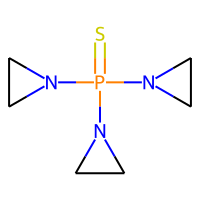
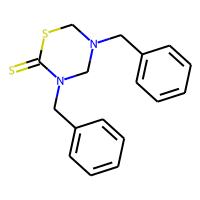
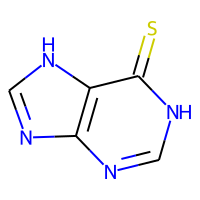
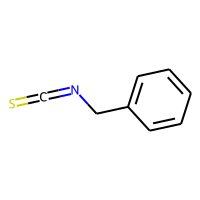
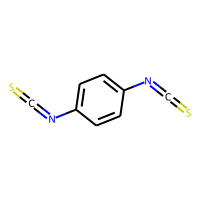
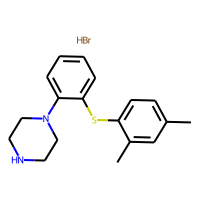
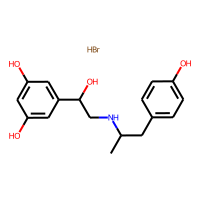
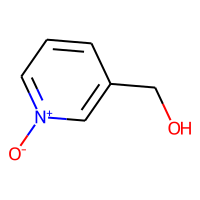
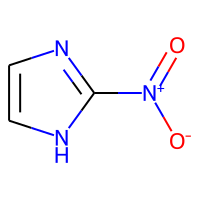
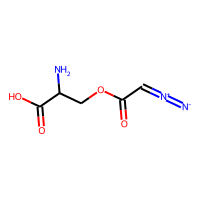

In [74]:
train = trainset_df[trainset_df["smiles"].isin(remained_smiles)]
train['mol'] =trainset_mol_list
train

In [100]:
 trainset_df[trainset_df["cas"]==1920]

Anti                                             smiles   cas
769     0  COc1ccc2cc3[n+](cc2c1OC)CCc1cc2c(cc1-3)OCO2.[Cl-]  1920

In [77]:
testset_df = pd.read_csv('Anti_QAC_predict.csv')
test_smilesList = testset_df.smiles.values
print("number of all smiles: ",len(test_smilesList))

number of all smiles:  52


In [78]:
testset_mol_list = []
test_remained_smiles = []
for smiles in test_smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        test_remained_smiles.append(smiles)
        testset_mol_list.append(mol)
    except:
        print("not successfully processed smiles: ", smiles)
        pass

Anti                                             smiles  CAS  \
0      1        COc1ccc2cc3[n+](cc2c1OC)CCc1cc2c(cc1-3)OCO2    1   
1      1       COc1cc2c(cc1OC)-c1cc3ccc(OC)c(OC)c3c[n+]1CC2    2   
2      1                                CCCCCCCC[N+](C)(C)C    3   
3      1                              CCCCCCCCCC[N+](C)(C)C    4   
4      1                            CCCCCCCCCCCC[N+](C)(C)C    5   
5      1                          CCCCCCCCCCCCCC[N+](C)(C)C    6   
6      1                        CCCCCCCCCCCCCCCC[N+](C)(C)C    7   
7      1                      CCCCCCCCCCCCCCCCCC[N+](C)(C)C    8   
8      1                    CCCCCCCCCCCCCCCCCCCC[N+](C)(C)C    9   
9      1                  CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C   10   
10     1                CCCCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C   11   
11     1                         CCCCCCCC[N+](C)(C)CCCCCCCC   12   
12     1                       CCCCCCCCCC[N+](C)(C)CCCCCCCC   13   
13     1                     CCCCCCCCCC[N+](C)(C)CCCCCCCCCC   14   
14     1                   CCCCCCCCCCCC[N+](C)(C)CCCCCCCCCC   15   
15     1                 CCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC   16   
16     1               CCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC   17   
17     1              CCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCC   18   
18     1             CCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCCC   19   
19     1                           CCCCCCCCCCCC[N+](C)(C)CC   20   
20     1                         CCCCCCCCCCCCCC[N+](C)(C)CC   21   
21     1                       CCCCCCCCCCCCCCCC[N+](C)(C)CC   22   
22     1                     CCCCCCCCCCCCCCCCCC[N+](C)(C)CC   23   
23     1                  CCCCCCCC[N+](C)(CCCCCCCC)CCCCCCCC   24   
24     1                        CCCCCCCC[N+](C)(C)Cc1ccccc1   25   
25     1                      CCCCCCCCCC[N+](C)(C)Cc1ccccc1   26   
26     1                    CCCCCCCCCCCC[N+](C)(C)Cc1ccccc1   27   
27     1                   CCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1   28   
28     1                  CCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1   29   
29     1                CCCCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1   30   
30     1              CCCCCCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1   31   
31     1  CC(C)(C)CC(C)(C)c1ccc(OCCOCC[N+](C)(C)Cc2ccccc...   32   
32     1                  CCCCCCCCCCCC[N+](C)(C)CCOc1ccccc1   33   
33     1              CCCCCCCCCCCCCC[N+](C)(C)Cc1ccc(CC)cc1   34   
34     1              CCCCCCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)O   35   
35     1            CCCCCCCCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)O   36   
36     1          CCCCCCCCCCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)O   37   
37     0  CCCCCCCCCCCCCCCC(=O)OCC[N+](C)(C)CCOC(=O)CCCCC...   38   
38     0  CCCCCCCCCCCCCCCCCC(=O)OCC[N+](C)(C)CCOC(=O)CCC...   39   
39     1               CCCCCCCCCCCCCCCC(=O)OCC[N+](C)(C)CCO   40   
40     1             CCCCCCCCCCCCCCCCCC(=O)OCC[N+](C)(C)CCO   41   
41     1             CCCCCCCCCCCCCCCC(=O)OCC[N+](C)(CCO)CCO   42   
42     1           CCCCCCCCCCCCCCCCCC(=O)OCC[N+](C)(CCO)CCO   43   
43     1                          CCCCCCCCCCCC[N+](C)(C)CCO   44   
44     1                        CCCCCCCCCCCCCC[N+](C)(C)CCO   45   
45     1                      CCCCCCCCCCCCCCCC[N+](C)(C)CCO   46   
46     1                    CCCCCCCCCCCCCCCCCC[N+](C)(C)CCO   47   
47     1                        CCCCCCCCCCCC[N+](C)(CCO)CCO   48   
48     1                      CCCCCCCCCCCCCC[N+](C)(CCO)CCO   49   
49     1                  CCCCCCCCCCCCCCCCCC[N+](C)(CCO)CCO   50   
50     1                            CCCCCCCCCCCC[n+]1ccccc1   51   
51     1                        CCCCCCCCCCCCCCCC[n+]1ccccc1   52   

                                                  mol  
0   <img data-content="rdkit/molecule" src="data:i...  
1   <img data-content="rdkit/molecule" src="data:i...  
2   <img data-content="rdkit/molecule" src="data:i...  
3   <img data-content="rdkit/molecule" src="data:i...  
4   <img data-content="rdkit/molecule" src="data:i...  
5   <img data-content="rdkit/molecule" src="data:i...  
6   <im
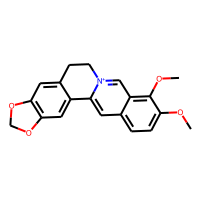
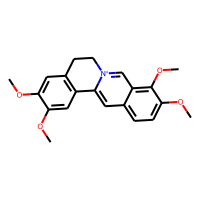
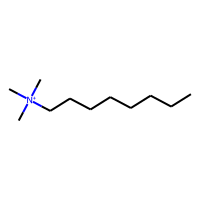
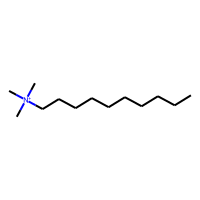
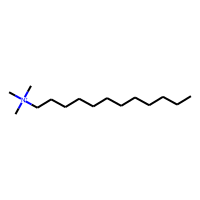
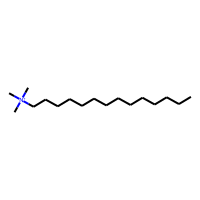
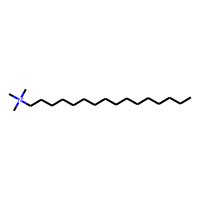
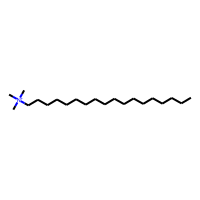
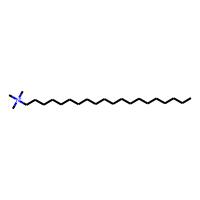
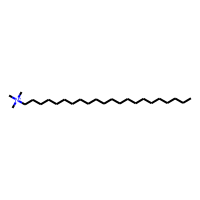
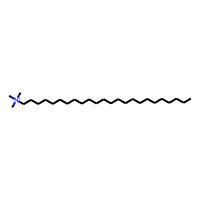
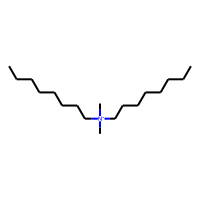
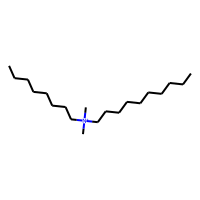
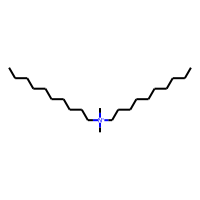
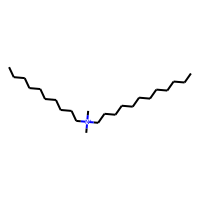
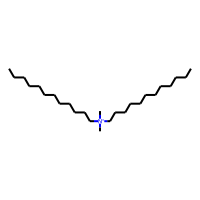
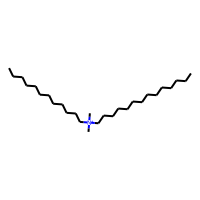
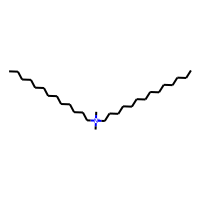
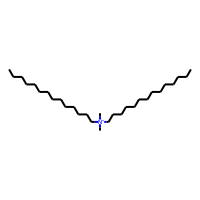
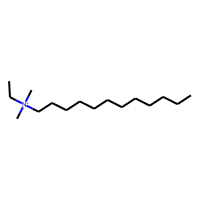
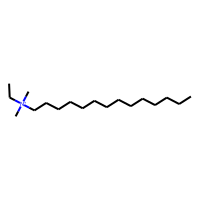
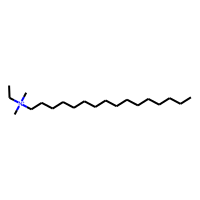
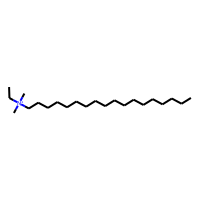
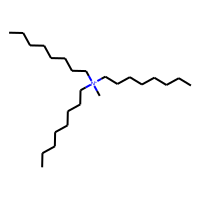
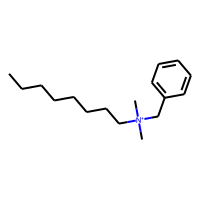
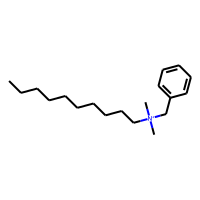
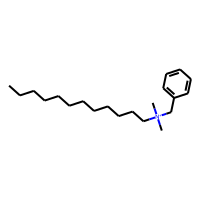
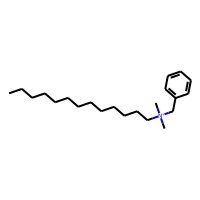
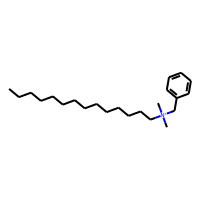
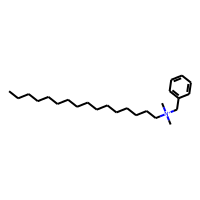
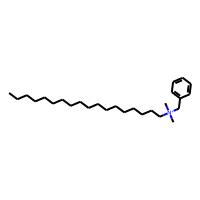
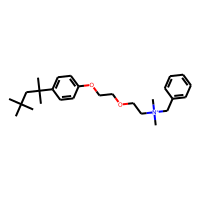
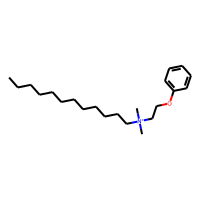
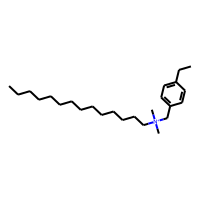
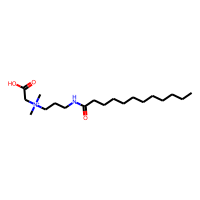
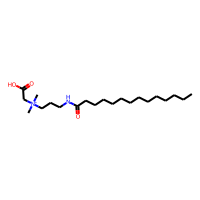
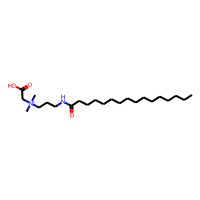
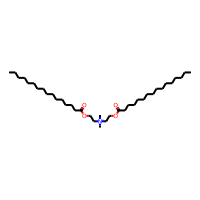
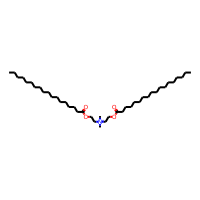
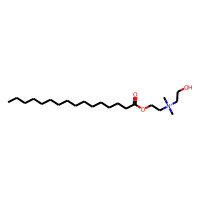
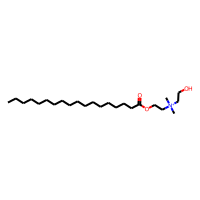
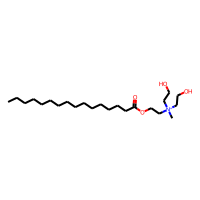
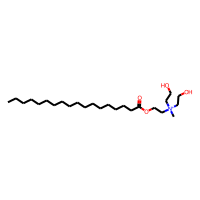
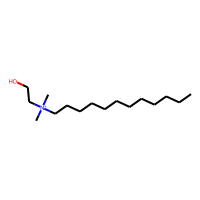
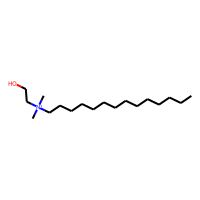
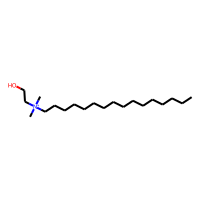
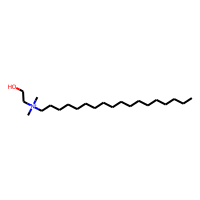
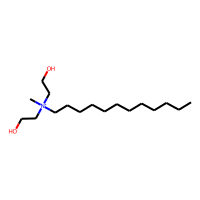
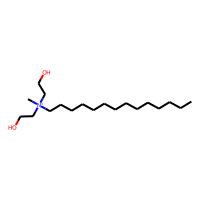
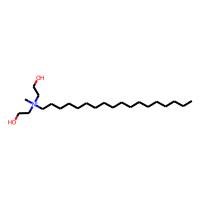
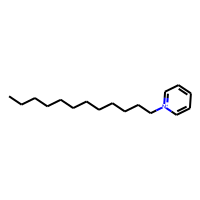
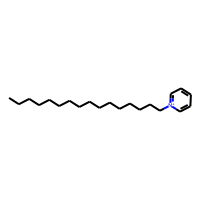

In [79]:
test = testset_df[testset_df["smiles"].isin(test_remained_smiles)]
test['mol'] =testset_mol_list
test

In [45]:
# Training set
def calcfp(mol,funcFPInfo=dict(radius=3, nBits=2048, useFeatures=False, useChirality = False)):
    fp = GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('bit_')
    return fp

morgan_train = train.mol.apply(calcfp)
morgan_train.shape

(2928, 2048)

In [80]:
# Test set
morgan_test = test.mol.apply(calcfp)
morgan_test.shape

(52, 2048)

In [83]:
X_train = morgan_train
X_test = morgan_test

In [85]:
distances = calc_training_dist_matrix(X_train)

In [86]:
D_cutoff = calc_d_cutoff(distances)
print(D_cutoff)

10.281364747155852


In [87]:
test_set_distances = calc_test_distances(X_test,X_train)

In [88]:
test_values = np.apply_along_axis(calc_d_cutoff,1,test_set_distances)

In [89]:
test_values.shape

(52,)

In [90]:
v_test_AD = np.vectorize(test_AD)
test_AD_results = v_test_AD(test_values,D_cutoff)

In [91]:
test['Applicability_Domain'] = test_AD_results
test['Applicability_Domain'] = test.Applicability_Domain.map(lambda x: "Reliable" if x else "Unreliable")

In [96]:
test.iloc[:,[0,1,2,4]]

Anti                                             smiles  CAS  \
0      1        COc1ccc2cc3[n+](cc2c1OC)CCc1cc2c(cc1-3)OCO2    1   
1      1       COc1cc2c(cc1OC)-c1cc3ccc(OC)c(OC)c3c[n+]1CC2    2   
2      1                                CCCCCCCC[N+](C)(C)C    3   
3      1                              CCCCCCCCCC[N+](C)(C)C    4   
4      1                            CCCCCCCCCCCC[N+](C)(C)C    5   
5      1                          CCCCCCCCCCCCCC[N+](C)(C)C    6   
6      1                        CCCCCCCCCCCCCCCC[N+](C)(C)C    7   
7      1                      CCCCCCCCCCCCCCCCCC[N+](C)(C)C    8   
8      1                    CCCCCCCCCCCCCCCCCCCC[N+](C)(C)C    9   
9      1                  CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C   10   
10     1                CCCCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C   11   
11     1                         CCCCCCCC[N+](C)(C)CCCCCCCC   12   
12     1                       CCCCCCCCCC[N+](C)(C)CCCCCCCC   13   
13     1                     CCCCCCCCCC[N+](C)(C)CCCCCCCCCC   14   
14     1                   CCCCCCCCCCCC[N+](C)(C)CCCCCCCCCC   15   
15     1                 CCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC   16   
16     1               CCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC   17   
17     1              CCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCC   18   
18     1             CCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCCC   19   
19     1                           CCCCCCCCCCCC[N+](C)(C)CC   20   
20     1                         CCCCCCCCCCCCCC[N+](C)(C)CC   21   
21     1                       CCCCCCCCCCCCCCCC[N+](C)(C)CC   22   
22     1                     CCCCCCCCCCCCCCCCCC[N+](C)(C)CC   23   
23     1                  CCCCCCCC[N+](C)(CCCCCCCC)CCCCCCCC   24   
24     1                        CCCCCCCC[N+](C)(C)Cc1ccccc1   25   
25     1                      CCCCCCCCCC[N+](C)(C)Cc1ccccc1   26   
26     1                    CCCCCCCCCCCC[N+](C)(C)Cc1ccccc1   27   
27     1                   CCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1   28   
28     1                  CCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1   29   
29     1                CCCCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1   30   
30     1              CCCCCCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1   31   
31     1  CC(C)(C)CC(C)(C)c1ccc(OCCOCC[N+](C)(C)Cc2ccccc...   32   
32     1                  CCCCCCCCCCCC[N+](C)(C)CCOc1ccccc1   33   
33     1              CCCCCCCCCCCCCC[N+](C)(C)Cc1ccc(CC)cc1   34   
34     1              CCCCCCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)O   35   
35     1            CCCCCCCCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)O   36   
36     1          CCCCCCCCCCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)O   37   
37     0  CCCCCCCCCCCCCCCC(=O)OCC[N+](C)(C)CCOC(=O)CCCCC...   38   
38     0  CCCCCCCCCCCCCCCCCC(=O)OCC[N+](C)(C)CCOC(=O)CCC...   39   
39     1               CCCCCCCCCCCCCCCC(=O)OCC[N+](C)(C)CCO   40   
40     1             CCCCCCCCCCCCCCCCCC(=O)OCC[N+](C)(C)CCO   41   
41     1             CCCCCCCCCCCCCCCC(=O)OCC[N+](C)(CCO)CCO   42   
42     1           CCCCCCCCCCCCCCCCCC(=O)OCC[N+](C)(CCO)CCO   43   
43     1                          CCCCCCCCCCCC[N+](C)(C)CCO   44   
44     1                        CCCCCCCCCCCCCC[N+](C)(C)CCO   45   
45     1                      CCCCCCCCCCCCCCCC[N+](C)(C)CCO   46   
46     1                    CCCCCCCCCCCCCCCCCC[N+](C)(C)CCO   47   
47     1                        CCCCCCCCCCCC[N+](C)(CCO)CCO   48   
48     1                      CCCCCCCCCCCCCC[N+](C)(CCO)CCO   49   
49     1                  CCCCCCCCCCCCCCCCCC[N+](C)(CCO)CCO   50   
50     1                            CCCCCCCCCCCC[n+]1ccccc1   51   
51     1                        CCCCCCCCCCCCCCCC[n+]1ccccc1   52   

   Applicability_Domain  
0            Unreliable  
1            Unreliable  
2              Reliable  
3              Reliable  
4              Reliable  
5              Reliable  
6              Reliable  
7              Reliable  
8              Reliable  
9              Reliable  
10             Reliable  
11             Reliable  
12             Reliable  
13             Reliable  
14       